In [1]:
import os
os.system('clear')

import numpy as np
import pandas as pd

from termcolor import colored
from SecretColors.palette import Palette
material = Palette("material", color_mode = 'hexa')

# from colour import Color
hex_salmon = '#F68F83'
hex_gold = '#BC9661'
hex_indigo = '#2D2E5F'
hex_maroon = '#8C4750'
hex_white = '#FAFAFA'
hex_blue = '#7EB5D2'

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'SF Compact Text'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.titleweight'] = 'semibold'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[hex_indigo, hex_salmon, hex_maroon])

# os.chdir("./nordpool")

In [2]:
flist = [f for f in sorted(os.listdir("./raw")) if not f.startswith('.') or f.startswith('~')]

print(flist)

for filename in flist:
    print(filename)
    df = pd.read_excel(f"./raw/{filename}", header = None, skip_blank_lines=True, decimal=',', thousands='.')
    df = df.replace('Instrument code', 'Instrumentcode')
    df = df.replace('Contract type', 'Contracttype')
    df = df.dropna(how = 'all', axis = 0)
    df = df.dropna(how = 'all', axis = 1)
    df = df.reset_index(drop = True)
    
    df.columns = df.iloc[0]
    df = df.drop(0)

    df1 = df[~df['Instrumentcode'].str.contains('NL ID ')]
    df2 = df[df['Instrumentcode'].str.contains('NL ID ')]

    df1['Date'] = pd.to_datetime(df1['Instrumentcode'].str[:7], format = '%d%b%y')
    df2['Date'] = pd.to_datetime(df2['Instrumentcode'].str.replace("NL ID ", "").str[:7], format = '%y%b%d')
    # df1 = del df1['Instrumentcode']
    # df1 = df1.drop(['Instrumentcode'], axis=1)
    # df2 = df2.drop(['Instrumentcode'], axis=1)
    # df = df1.merge(df2, left_index = True, right_index = True)
    df = pd.concat([df1, df2]).sort_index()

    df.to_pickle(f"./{os.path.splitext(filename)[0]}.pkl")

    # print(df)

    # Combined = pd.concat(df1,df2)

    # for row in df['Instrumentcode']:
    #     if "NL ID " in row:
    #        d.append(pd.to_datetime(df['Instrumentcode'].str.replace("NL ID ", "").str[:7], format = '%d%b%y'))
    #     else:
    #         d.append(pd.to_datetime(df['Instrumentcode'].str.replace("NL ID ", "").str[:7], format = '%d%b%y'))

    # df['Date']. = pd.to_datetime(df['Instrumentcode'].str.replace("NL ID ", "").str[:7], format = '%d%b%y')

['2006_Intraday.xls', '2007_Intraday.xls', '2008_Intraday.xls', '2009_Intraday.xls', '2010_Intraday.xls', '2011_Intraday.xls', '2012_Intraday.xls', '2013_Intraday.xls', '2014_Intraday.xlsx', '2015_Intraday.xlsx', '2016_Intraday.xlsx', '2017_Intraday.xlsx', '2018_Intraday.xlsx', '2019_Intraday.xlsx']
2006_Intraday.xls
2007_Intraday.xls
2008_Intraday.xls
2009_Intraday.xls
2010_Intraday.xls
2011_Intraday.xls
2012_Intraday.xls
2013_Intraday.xls
2014_Intraday.xlsx
2015_Intraday.xlsx
2016_Intraday.xlsx
2017_Intraday.xlsx
2018_Intraday.xlsx
2019_Intraday.xlsx


0       Instrumentcode  Side Volume Price Contracttype  \
1     14SEP06 - PTE 93  sell     10    45         Spot   
2      14SEP06 - 1H 13   buy      5   100         Spot   
3      14SEP06 - 1H 14   buy      5   100         Spot   
4      14SEP06 - 1H 13  sell      5   100         Spot   
5      14SEP06 - 1H 14  sell      5   100         Spot   
...                ...   ...    ...   ...          ...   
1084   28DEC06 - 2H 04   buy     25    38         Spot   
1085   28DEC06 - 2H 05   buy     10    37         Spot   
1086   28DEC06 - 2H 05   buy     25    38         Spot   
1087   28DEC06 - 2H 06   buy     25    38         Spot   
1088   28DEC06 - 2H 07   buy     25    38         Spot   

0    Creation timestamp (GMT)       Date  
1         2006-09-14 10:58:31 2006-09-14  
2         2006-09-14 05:49:36 2006-09-14  
3         2006-09-14 05:49:40 2006-09-14  
4         2006-09-14 05:49:36 2006-09-14  
5         2006-09-14 05:49:40 2006-09-14  
...                       ...        ...  
10

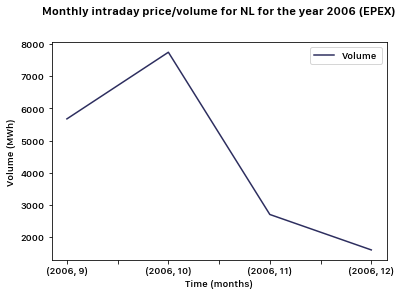

0      Instrumentcode  Side Volume  Price Contracttype  \
1     02JAN07 - 1H 11  sell   18.5  48.15         Spot   
2     02JAN07 - 1H 12  sell   17.3  49.93         Spot   
3     02JAN07 - 1H 13  sell   16.6     49         Spot   
4     02JAN07 - 1H 14  sell   15.2  46.01         Spot   
5     02JAN07 - 1H 15  sell   12.1  37.57         Spot   
...               ...   ...    ...    ...          ...   
2192  23DEC07 - 1H 21  sell      5  89.96         Spot   
2193  23DEC07 - 1H 22  sell      5  79.91         Spot   
2194  23DEC07 - 1H 23  sell      5     82         Spot   
2195  24DEC07 - 1H 21  sell     35     69         Spot   
2196  24DEC07 - 1H 21   buy     35     69         Spot   

0    Creation timestamp (GMT)       Date  
1         2007-01-02 07:17:13 2007-01-02  
2         2007-01-02 07:17:13 2007-01-02  
3         2007-01-02 07:17:13 2007-01-02  
4         2007-01-02 07:17:38 2007-01-02  
5         2007-01-02 07:18:22 2007-01-02  
...                       ...        ...  
21

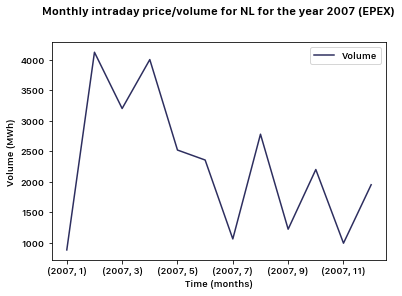

0      Instrumentcode  Side Volume Price Contracttype  \
1     02JAN08 - 1H 11   buy     10    90         Spot   
2     02JAN08 - 1H 11  sell     10    90         Spot   
3     02JAN08 - 1H 12   buy     10    95         Spot   
4     02JAN08 - 1H 12  sell     10    95         Spot   
5     02JAN08 - 1H 13   buy     10   100         Spot   
...               ...   ...    ...   ...          ...   
3428  30DEC08 - 1H 12  sell     10    59         Spot   
3429  30DEC08 - 1H 13  sell      5    75         Spot   
3430  30DEC08 - 1H 14  sell      5    75         Spot   
3431  30DEC08 - 1H 18  sell      5    80         Spot   
3432  30DEC08 - 1H 19  sell      5    80         Spot   

0    Creation timestamp (GMT)       Date  
1         2008-01-02 07:29:21 2008-01-02  
2         2008-01-02 07:29:21 2008-01-02  
3         2008-01-02 07:29:39 2008-01-02  
4         2008-01-02 07:29:39 2008-01-02  
5         2008-01-02 07:30:17 2008-01-02  
...                       ...        ...  
3428      2008

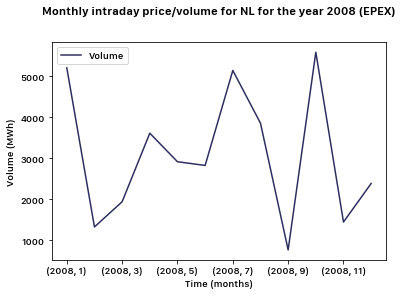

0      Instrumentcode  Side Volume Price Contracttype  \
1     08MAR08 - 1H 13   buy     10   100         Spot   
2     08MAR08 - 1H 14   buy     10   100         Spot   
3     08MAR08 - 1H 15   buy     10   100         Spot   
4     08MAR08 - 1H 16   buy     10   100         Spot   
5     08MAR08 - 1H 17   buy     10   100         Spot   
...               ...   ...    ...   ...          ...   
7792  29DEC09 - 1H 18  sell     25    46         Spot   
7793  29DEC09 - 1H 19  sell     25    47         Spot   
7794  29DEC09 - 1H 20  sell     25    43         Spot   
7795  29DEC09 - 1H 21  sell     25    35         Spot   
7796  29DEC09 - 1H 22  sell     25    31         Spot   

0    Creation timestamp (GMT)       Date  
1         2008-03-08 08:36:59 2008-03-08  
2         2008-03-08 08:37:21 2008-03-08  
3         2008-03-08 08:37:50 2008-03-08  
4         2008-03-08 08:37:57 2008-03-08  
5         2008-03-08 08:38:06 2008-03-08  
...                       ...        ...  
7792      2009

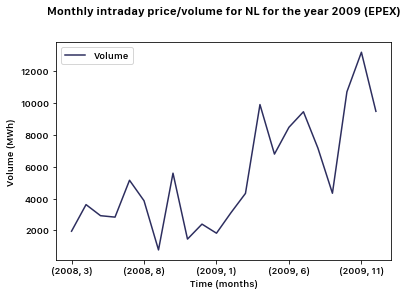

0      Instrumentcode  Side Volume Price Contracttype  \
1     02JAN10 - 1H 19   buy     20    61         Spot   
2     02JAN10 - 1H 20   buy     20    61         Spot   
3     02JAN10 - 1H 21   buy     20    55         Spot   
4     02JAN10 - 1H 22   buy     20    44         Spot   
5     02JAN10 - 1H 23   buy     20    46         Spot   
...               ...   ...    ...   ...          ...   
2486  28DEC10 - 1H 21   buy     15    66         Spot   
2487  28DEC10 - 1H 13  sell     15    72         Spot   
2488  28DEC10 - 1H 14  sell     15    68         Spot   
2489  28DEC10 - 1H 15  sell     15    64         Spot   
2490  28DEC10 - 1H 21  sell     15    66         Spot   

0    Creation timestamp (GMT)       Date  
1         2010-01-02 10:22:43 2010-01-02  
2         2010-01-02 10:22:46 2010-01-02  
3         2010-01-02 12:21:52 2010-01-02  
4         2010-01-02 10:21:36 2010-01-02  
5         2010-01-02 10:21:39 2010-01-02  
...                       ...        ...  
2486      2010

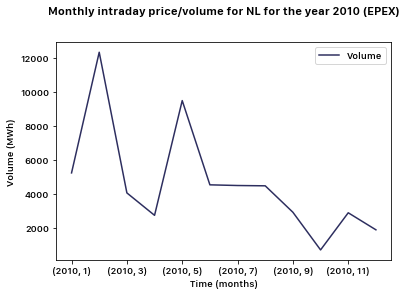

0      Instrumentcode  Side Volume Price Contracttype  \
1     01JAN11 - 1H 15  sell     10    31         Spot   
2     01JAN11 - 1H 16  sell     10    20         Spot   
3     01JAN11 - 1H 17  sell     10    31         Spot   
4     01JAN11 - 1H 18  sell     10    46         Spot   
5     01JAN11 - 1H 19  sell     10    50         Spot   
...               ...   ...    ...   ...          ...   
6098  30DEC11 - 1H 03  sell    200    35         Spot   
6099  30DEC11 - 1H 04  sell    200    35         Spot   
6100  30DEC11 - 1H 05  sell    200    35         Spot   
6101  30DEC11 - 1H 06  sell    200    35         Spot   
6102  30DEC11 - 1H 07  sell    200    35         Spot   

0    Creation timestamp (GMT)       Date  
1         2011-01-01 11:00:51 2011-01-01  
2         2011-01-01 11:00:51 2011-01-01  
3         2011-01-01 11:00:51 2011-01-01  
4         2011-01-01 11:00:51 2011-01-01  
5         2011-01-01 11:00:51 2011-01-01  
...                       ...        ...  
6098      2011

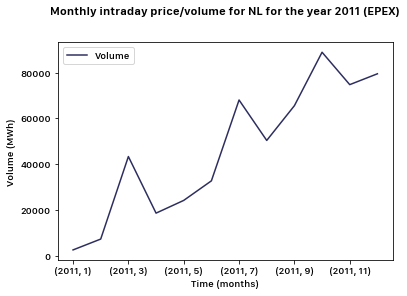

0       Instrumentcode  Side Volume Price Contracttype  \
1      01JAN12 - 1H 07   buy      4     0         Spot   
2      01JAN12 - 1H 07  sell      4     0         Spot   
3      03JAN12 - 1H 24   buy     50    28         Spot   
4      03JAN12 - 1H 24   buy     50    28         Spot   
5      03JAN12 - 1H 24  sell     50    28         Spot   
...                ...   ...    ...   ...          ...   
16962  31DEC12 - 1H 06  sell     50    10         Spot   
16963  31DEC12 - 1H 12   buy     10    45         Spot   
16964  31DEC12 - 1H 10  sell     10    55         Spot   
16965  31DEC12 - 1H 14  sell      5    60         Spot   
16966  31DEC12 - 1H 15  sell     10    50         Spot   

0     Creation timestamp (GMT)       Date  
1          2011-12-31 19:41:58 2012-01-01  
2          2011-12-31 19:41:58 2012-01-01  
3          2012-01-03 17:51:50 2012-01-03  
4          2012-01-03 17:51:50 2012-01-03  
5          2012-01-03 17:51:50 2012-01-03  
...                        ...        .

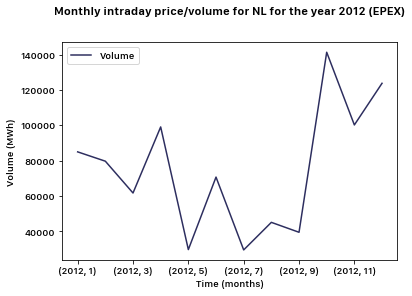

0       Instrumentcode  Side Volume Price Contracttype  \
1      01JAN13 - 1H 01   buy     15    20         Spot   
2      01JAN13 - 1H 02   buy     15    20         Spot   
3      01JAN13 - 1H 03   buy     15    20         Spot   
4      01JAN13 - 1H 01  sell     10    20         Spot   
5      01JAN13 - 1H 01  sell     15    20         Spot   
...                ...   ...    ...   ...          ...   
43196  31DEC13 - 1H 24   buy      1    35         Spot   
43197  31DEC13 - 1H 24   buy      5    30         Spot   
43198  31DEC13 - 1H 24   buy      5    30         Spot   
43199  31DEC13 - 1H 24   buy     15    34         Spot   
43200  31DEC13 - 1H 24   buy     45    30         Spot   

0     Creation timestamp (GMT)       Date  
1          2012-12-31 19:51:44 2013-01-01  
2          2012-12-31 19:51:44 2013-01-01  
3          2012-12-31 19:51:44 2013-01-01  
4          2012-12-31 19:51:44 2013-01-01  
5          2012-12-31 19:51:44 2013-01-01  
...                        ...        .

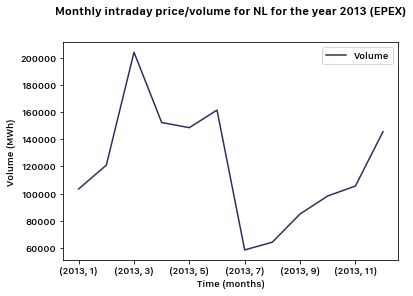

0       Instrumentcode  Side Volume Price Contracttype  \
1      01JAN14 - 1H 04   buy     30    23         Spot   
2      01JAN14 - 1H 04  sell     30    23         Spot   
3      01JAN14 - 1H 01   buy     30    29         Spot   
4      01JAN14 - 1H 01  sell     30    29         Spot   
5      01JAN14 - 1H 02   buy     23  28.3         Spot   
...                ...   ...    ...   ...          ...   
68794  31DEC14 - 1H 12  sell     15    49         Spot   
68795  31DEC14 - 1H 13  sell     21    48         Spot   
68796  31DEC14 - 1H 14  sell     25    46         Spot   
68797  31DEC14 - 1H 23  sell      5    30         Spot   
68798  31DEC14 - 1H 24  sell     12    25         Spot   

0     Creation timestamp (GMT)       Date  
1          2013-12-31 20:42:45 2014-01-01  
2          2013-12-31 20:42:45 2014-01-01  
3          2013-12-31 20:42:45 2014-01-01  
4          2013-12-31 20:42:45 2014-01-01  
5          2013-12-31 20:42:47 2014-01-01  
...                        ...        .

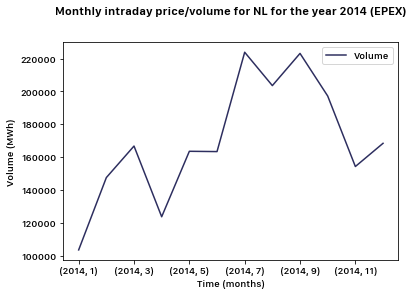

0             Instrumentcode  Side Price Volume Contracttype  \
1            01JAN15 - 1H 01   buy    25      1         Spot   
2            01JAN15 - 1H 01  sell    25      1         Spot   
3            01JAN15 - 1H 01   buy  24.4      5         Spot   
4            01JAN15 - 1H 01  sell  24.4      5         Spot   
5            01JAN15 - 1H 01   buy    28      4         Spot   
...                      ...   ...   ...    ...          ...   
83352  NL ID 15DEC31 - 1H-22  sell    40      2         Spot   
83353  NL ID 15DEC31 - 1H-23   buy    40      2         Spot   
83354  NL ID 15DEC31 - 1H-23  sell    40      2         Spot   
83355  NL ID 15DEC31 - 1H-22   buy    26     20         Spot   
83356  NL ID 15DEC31 - 1H-22  sell    26     20         Spot   

0        Creation timestamp (GMT)       Date  
1      2014-12-31 20:43:24.081000 2015-01-01  
2      2014-12-31 20:43:24.081000 2015-01-01  
3      2014-12-31 20:43:24.098000 2015-01-01  
4      2014-12-31 20:43:24.098000 2015-01-0

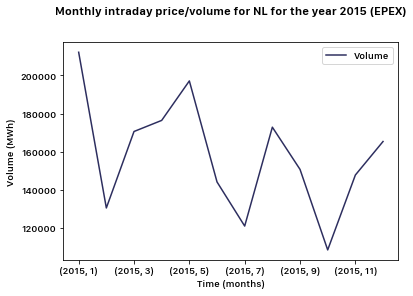

0              Instrumentcode  Side Price Volume Contracttype  \
1       NL ID 16JAN01 - 1H-02   buy     6      4         Spot   
2       NL ID 16JAN01 - 1H-02  sell     6      4  CrossBorder   
3       NL ID 16JAN01 - 1H-03   buy     6      4         Spot   
4       NL ID 16JAN01 - 1H-03  sell     6      4  CrossBorder   
5       NL ID 16JAN01 - 1H-04   buy    40      4  CrossBorder   
...                       ...   ...   ...    ...          ...   
114142  NL ID 16DEC31 - 1H-23  sell    35    1.9         Spot   
114143  NL ID 16DEC31 - 1H-21   buy    48      2         Spot   
114144  NL ID 16DEC31 - 1H-21  sell    48      2         Spot   
114145  NL ID 16DEC31 - 1H-24   buy    47     50         Spot   
114146  NL ID 16DEC31 - 1H-24  sell    47     50         Spot   

0         Creation timestamp (GMT)       Date  
1       2015-12-31 22:18:29.314000 2016-01-01  
2       2015-12-31 22:18:29.314000 2016-01-01  
3       2015-12-31 22:18:34.322000 2016-01-01  
4       2015-12-31 22:18:34

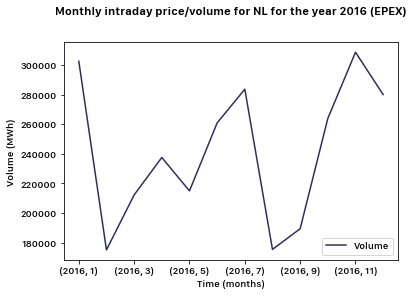

0              Instrumentcode  Side Price Volume Contracttype  \
1       NL ID 17JAN01 - 1H-01   buy    40     30  CrossBorder   
2       NL ID 17JAN01 - 1H-01  sell    40     30         Spot   
3       NL ID 17JAN01 - 1H-02   buy    45    0.1  CrossBorder   
4       NL ID 17JAN01 - 1H-02   buy    45     30  CrossBorder   
5       NL ID 17JAN01 - 1H-02  sell    45    0.1         Spot   
...                       ...   ...   ...    ...          ...   
359616        31DEC17 - 1H 24  sell  31.6      3  CrossBorder   
359617  NL ID 17DEC31 - 1H-24   buy    22     15  CrossBorder   
359618  NL ID 17DEC31 - 1H-24  sell    22     15         Spot   
359619  NL ID 17DEC31 - 1H-24   buy    23     10  CrossBorder   
359620  NL ID 17DEC31 - 1H-24  sell    23     10         Spot   

0         Creation timestamp (GMT)       Date  
1              2016-12-31 20:00:09 2017-01-01  
2              2016-12-31 20:00:09 2017-01-01  
3              2016-12-31 20:00:09 2017-01-01  
4              2016-12-31 2

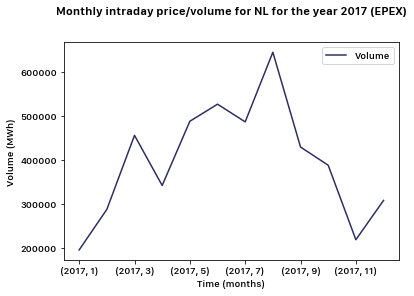

0              Instrumentcode  Side  Price Volume Contracttype  \
1       NL ID 18JAN01 - 1H-12   buy  29.95    159         Spot   
2       NL ID 18JAN01 - 1H-12  sell  29.95    159  CrossBorder   
3       NL ID 18JAN01 - 1H-13   buy  29.95     73         Spot   
4       NL ID 18JAN01 - 1H-13  sell  29.95     73  CrossBorder   
5       NL ID 18JAN01 - 1H-14   buy  34.95     13         Spot   
...                       ...   ...    ...    ...          ...   
817032  NL ID 18DEC31 - 1H-24  sell     40    0.3         Spot   
817033  NL ID 18DEC31 - 1H-23   buy     50    0.3         Spot   
817034  NL ID 18DEC31 - 1H-23  sell     50    0.3         Spot   
817035  NL ID 18DEC31 - 1H-24   buy     49     20         Spot   
817036  NL ID 18DEC31 - 1H-24  sell     49     20         Spot   

0      Creation timestamp (GMT)       Date  
1           2017-12-31 20:00:00 2018-01-01  
2           2017-12-31 20:00:00 2018-01-01  
3           2017-12-31 20:00:00 2018-01-01  
4           2017-12-31 20:0

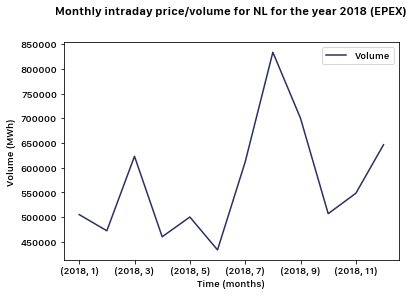

0               Instrumentcode  Side  Price Volume Contracttype  \
1        NL ID 19JAN01 - 1H-01   buy     78     10         Spot   
2        NL ID 19JAN01 - 1H-01  sell     78     10         Spot   
3        NL ID 19JAN01 - 1H-01   buy     60      2         Spot   
4        NL ID 19JAN01 - 1H-01  sell     60      2         Spot   
5        NL ID 19JAN01 - 1H-01   buy     78     25         Spot   
...                        ...   ...    ...    ...          ...   
1041550  NL ID 19JUL09 - 1H-22   buy  44.99    4.4  CrossBorder   
1041551  NL ID 19JUL10 - 1H-09   buy     51  100.4         Spot   
1041552  NL ID 19JUL10 - 1H-09  sell     51  100.4  CrossBorder   
1041553  NL ID 19JUL10 - 1H-08   buy     52      5         Spot   
1041554  NL ID 19JUL10 - 1H-08  sell     52      5  CrossBorder   

0       Creation timestamp (GMT)       Date  
1            31-12-2018 16:47:42 2019-01-01  
2            31-12-2018 16:47:42 2019-01-01  
3            31-12-2018 16:56:41 2019-01-01  
4          

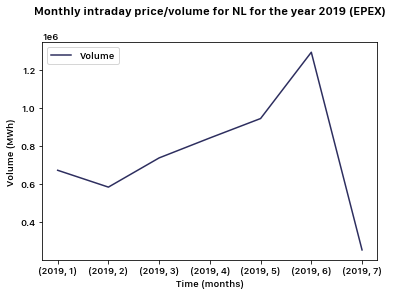

In [3]:
years = ['2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
# years = ['2006']
country = 'NL'

dfo = pd.DataFrame()
buy = []
sell = []
breaks = []

for y in years:
    df = pd.read_pickle(f"./{y}_Intraday.pkl")
    print(df)

    volume_buy = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'buy', 'Volume'].sum()
    volume_sell = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'sell', 'Volume'].sum()

    price_buy = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'buy', 'Price'].sum()
    price_sell = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'sell', 'Price'].sum()

    df_group = df.drop(['Instrumentcode', 'Contracttype'], axis=1).groupby([(df['Date'].dt.year),(df['Date'].dt.month)]).sum()
    # df_group = df_group.drop(['Contracttype', 'Instrumentcode', 'Side'], axis=1)
    print(df_group)
    # df_group = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'buy'].groupby([(df['Date'].dt.year),(df['Date'].dt.month)]).sum()
    # df_group2 = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'sell'].groupby([(df['Date'].dt.year),(df['Date'].dt.month)]).sum()

    dfo = dfo.append(df_group, ignore_index = False)
    breaks.append(len(dfo))
    
    # buy.append(df['Buy'].sum())
    # sell.append(df['Sell'].sum())

    df_group[['Volume']].plot(legend=True)
    plt.title(f'Monthly intraday price/volume for {country} for the year {y} (EPEX)', y = 1.1)
    # plt.xlim(0,50)
    # plt.ylim(0, 1500)
    plt.xlabel(r'Time (months)')
    plt.ylabel(r'Volume (MWh)')
    plt.show()

    # df_group2[['Volume']].plot(legend=True)
    # plt.title(f'Monthly intraday price/volume for {country} for the year {y} (EPEX)', y = 1.1)
    # # plt.xlim(0,50)
    # # plt.ylim(0, 1500)
    # plt.xlabel(r'Time (months)')
    # plt.ylabel(r'Volume (MWh)')
    # plt.show()

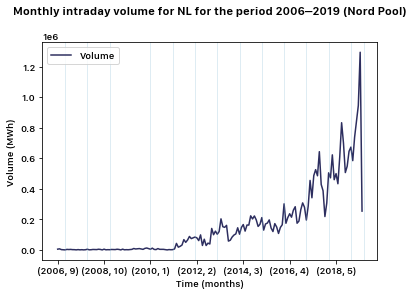

In [5]:
dfo[['Volume']].plot(legend=True)
plt.title(f'Monthly intraday volume for {country} for the period {years[0]}–{years[-1]} (Nord Pool)', y = 1.1)
# plt.xlim(0,50)
# plt.ylim(0, 1500)
plt.xlabel(r'Time (months)')
plt.ylabel(r'Volume (MWh)')
[plt.axvline(_breaks, color = hex_blue, alpha = 0.25, linewidth = 1) for _breaks in breaks]
plt.show()